# Описание проекта
Контекст
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

In [31]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st

In [32]:
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv')
    )
except:
    hypothesis, orders, visitors = (
        pd.read_csv('D:\IT\courses Python\yandex_practicum\\7_\hypothesis.csv'),
        pd.read_csv('D:\IT\courses Python\yandex_practicum\\7_\orders.csv'),
        pd.read_csv('D:\IT\courses Python\yandex_practicum\\7_\\visitors.csv')
    )

print('Дубликатов в hypothesis:', hypothesis.duplicated().sum())
hypothesis.info()
display(hypothesis.head(2))
print()
print('Дубликатов в orders:', orders.duplicated().sum())
orders.info()
display(orders.head(2))
print()
print('Дубликатов в visitors:', visitors.duplicated().sum())
visitors.info()
display(visitors.head(2))

Дубликатов в hypothesis: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10



Дубликатов в orders: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B



Дубликатов в visitors: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


## Описание данных
### Данные для первой части
#### Файл /datasets/hypothesis.csv. Скачать датасет
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
### Данные для второй части
#### Файл /datasets/orders.csv. Скачать датасет
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.
#### Файл /datasets/visitors.csv. Скачать датасет
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [33]:
# Применить дополнительную настройку, которая позволяет выводить бесконечное количество столбцов
pd.set_option('display.max_columns', None)

# Установим максимальную ширину столбца = 150
pd.options.display.max_colwidth = 150

# Приведем дату к нужному типу
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# Приведем к нижнему регистру названия столбцов
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Вывод
- Пропусков нет, дубликатов нет.
- в таблице hypothesis привели к нижнему регистру
- дату привели к типу дейттайм

## Часть 1. Приоритизация гипотез.
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

In [34]:
# Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_ice = hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).round(1)
hypothesis_ice.index.name = 'id' # Добавим название столбца с индексами
hypothesis_ice

,hypothesis,ICE
id,,
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


In [35]:
# Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета. 
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis_rice = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
hypothesis_rice.index.name = 'id'
hypothesis_rice

,hypothesis,RICE
id,,
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [36]:
# Объединим таблицы и отсортируем по убыванию RICE
hypothesis_ice.merge(hypothesis_rice, on='id', how='outer').sort_values(by='RICE', ascending=False)

,hypothesis_x,ICE,hypothesis_y,RICE
id,,,,
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

#### В фреймворк ICE наиболее перспективные гипотезы по убыванию:
- 8	-Запустить акцию, дающую скидку на товар в день рождения, 
- 0	-Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей, 
- 7	-Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, 
- 6	-Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

#### В фреймворк RICE наиболее перспективные гипотезы по убыванию: 
- 7	-Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, 
- 2	-Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа, 
- 0	-Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей, 
- 6	-Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

 8 гипотеза ушла на пятое место в фреймворк RICE, а 2 гипотеза вышла на второе место с пятого. Потому что у 2 гипотезы охват пользователей (reach) =8, а у 8 гипотезы охват (reach) =1.

## Часть 2. Анализ A/B-теста
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv

In [37]:
# Проверим сколько у нас групп в АВ-тесте и количество пользователей в каждой группе
print('В таблице orders:')
print(orders['group'].value_counts())
print()
print('В таблице visitors:')
print(visitors['group'].value_counts())

В таблице orders:
B    640
A    557
Name: group, dtype: int64

В таблице visitors:
A    31
B    31
Name: group, dtype: int64


В каждой таблице у нас по две группы.
В таблице заказов orders количество пользователей в группах не совпадает.

In [38]:
# Сколько пользователей в двух группах одновременно (по таблице с заказами)
orders.pivot_table(index='visitorId', values='group', aggfunc='nunique').query('group > 1').count()

group    58
dtype: int64

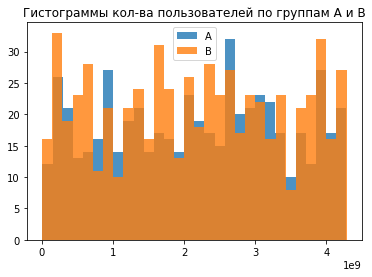

P-value:0.7777251763611774
Разница в количестве посетителей в группах A и B статистически НЕ значима

Базовая конверсия: 0.030
Измененная конверсия: 0.034
Минимальный обнаруживаемый эффект: 0.121


In [39]:
# Построим гистограмму 
plt.hist(orders[orders['group']=='A']['visitorId'], alpha = 0.8, label='A', bins = 30)
plt.hist(orders[orders['group']=='B']['visitorId'], alpha = 0.8, label='B', bins = 30)
plt.legend()
plt.title('Гистограммы кол-ва пользователей по группам A и B')
plt.show()
#Видны пики в большими заказами.
 
# Применим непараметрический тест Уилкоксона-Манна-Уитни для проверки стат.значимости различия в размере групп
results = st.mannwhitneyu(orders[orders['group']=='A']['visitorId'], orders[orders['group']=='B']['visitorId'])

alpha = 0.05 # критический уровень статистической значимости
print('P-value:{}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Разница в количестве посетителей в группах A и B статистически значима\n')
else:
    print('Разница в количестве посетителей в группах A и B статистически НЕ значима\n')

# Определим минимальный размер выборки для определения относительного различия между группами теста
baseline_conversion_rate = len(orders[orders['group']=='A']) / visitors[visitors['group']=='A']['visitors'].sum()
print('Базовая конверсия: {:.3f}'.format(baseline_conversion_rate))

changed_conversion = len(orders[orders['group']=='B']) / visitors[visitors['group']=='B']['visitors'].sum()
print('Измененная конверсия: {:.3f}'.format(changed_conversion))

minimum_detectable_effect = abs(1- baseline_conversion_rate / changed_conversion)
print('Минимальный обнаруживаемый эффект: {:.3f}'.format(minimum_detectable_effect))

Вводим базовую конверсию и полученный минимальный обнаруживаемый эффект в калькулятор.
Сайт калькулятора: https://www.evanmiller.org/ab-testing/sample-size.html
Получаем необходимое количество выборки 35855 для корректного проведения тестирования.

In [40]:
print('Общая сумма пользователей в группах: {}'.format(visitors['visitors'].sum()))

Общая сумма пользователей в группах: 37652


37652 пользователя > 35855 в калькуляторе.
Количество выборки для A/B тестирования корректно подобрано, статистически значимой разницы в количестве пользователей между группами нет

In [41]:
# Найдем даты начала и окончания теста
min_date = orders['date'].min()
max_date = orders['date'].max() 
print(min_date, "\n", max_date)

visitors['date'].describe()

2019-08-01 00:00:00 
 2019-08-31 00:00:00


C:\Users\nikit\AppData\Local\Temp\ipykernel_624\1753074706.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  visitors['date'].describe()


count                      62
unique                     31
top       2019-08-01 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Даты начала и окончания теста совпадают.

### Постройте график кумулятивной выручки по группам.

In [42]:
# Создаем массив уникальных пар значений дат и групп теста
date_group = orders[['date','group']].drop_duplicates()

# Соберём агрегированные кумулятивные по дням данные о заказах 
orders_agg = date_group.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}
    ), axis=1).sort_values(by=['date','group'])

In [43]:
# Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitors_agg = date_group.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}
    ), axis=1).sort_values(by=['date','group'])

In [44]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


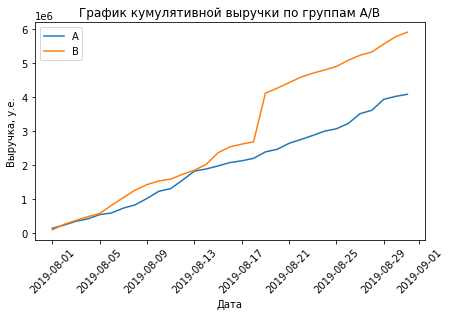

In [45]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulative[cumulative['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulative[cumulative['group']=='B'][['date','revenue', 'orders']]

# Изменим размер графика
plt.figure(figsize=(7,4))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

# Повернем записи по оси х на 45 градусов
plt.xticks(rotation=45)
plt.legend()
plt.title('График кумулятивной выручки по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.show()

Линия В на графике имеет резкий скачек, скорее всего связан с выбросом в заказах (возможно есть крупный заказ)
### Постройте график кумулятивного среднего чека по группам.

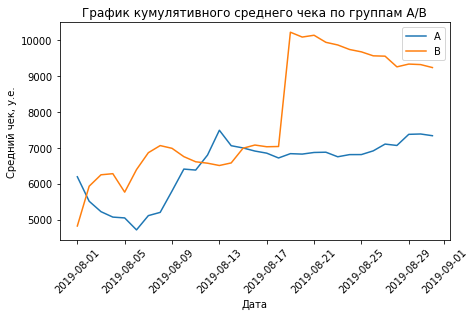

In [46]:
# разделим кумулятивную выручку на кумулятивное число заказов
plt.figure(figsize=(7,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Средний чек, у.е.')
plt.show()

Если линия группы А усреднилась с небольшими скачками с тенденцией вверх, то линия группы В после 17 числа имеет резкий скачек в среднем чеке, а потом идет на спад.
    
### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A.

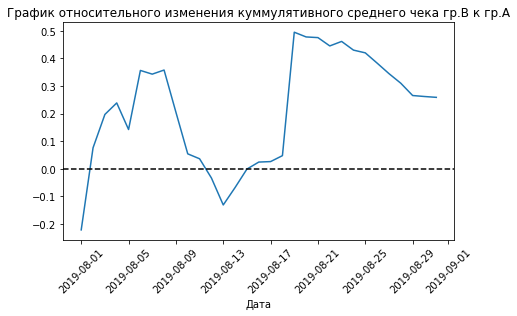

In [47]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(7,4))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.title('График относительного изменения куммулятивного среднего чека гр.В к гр.А')
plt.xlabel('Дата')
plt.show()

Стабильности тут нет. Виден тот же скачёк после 17 числа и спад.

### Постройте график кумулятивной конверсии по группам.

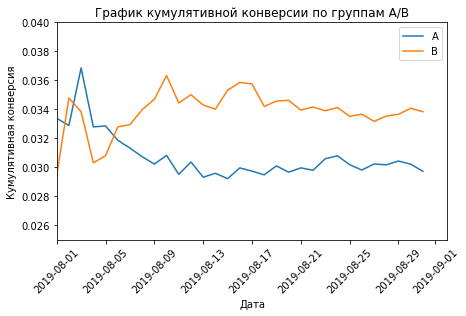

In [48]:
# считаем кумулятивную конверсию
cumulative['conversion'] = cumulative['orders']/cumulative['visitors']

# отделяем данные по группе A
cumulativeA = cumulative[cumulative['group']=='A']

# отделяем данные по группе B
cumulativeB = cumulative[cumulative['group']=='B']

# строим графики
plt.figure(figsize=(7,4))
plt.plot(cumulativeA['date'], cumulativeA['conversion'], label='A')
plt.plot(cumulativeB['date'], cumulativeB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 2), 0.025, 0.040])
plt.xticks(rotation=45)
plt.title('График кумулятивной конверсии по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.show()

С увеличением масштаба линии стали более рельефные. Сначала линии идут резкими скачками, а потом линия А пошла вниз и стабилизировалась. Линия В пошла вверх и к концу тоже стабилизировалась.

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A.

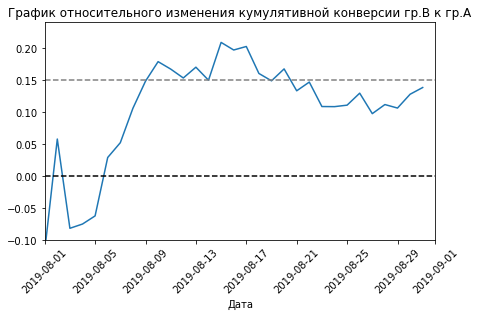

In [49]:
# Объединим таблицы
mergedCumulativeConversions = cumulativeA[['date','conversion']].merge(
    cumulativeB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(7,4))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']
         /mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.10, 0.24])
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивной конверсии гр.В к гр.А')
plt.xlabel('Дата')
plt.show()

Вначале конверсия группы В резкий подъем и спад, потом все-таки поднялась и теперь идет на поъеме в районе 15%.
### Постройте точечный график количества заказов по пользователям.

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5


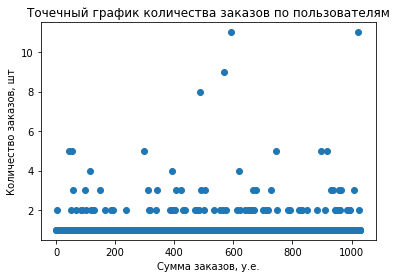

In [50]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']
print(ordersByUsers.sort_values(by='orders', ascending=False).head(5)) 

x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Сумма заказов, у.е.')
plt.ylabel('Количество заказов, шт')
plt.show()

Большинство пользователей совершают разовые покупки. И два пользователя делают по 11 заказов.
### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. 

In [51]:
# Выберите границу для определения аномальных пользователей.
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

5% пользователей сделали по два заказа, 1% - по 4 заказа. Выберем 2-3 заказа на одного пользователя за нижнюю границу числа заказов, и отсеем аномальных пользователей по ней.
### Постройте точечный график стоимостей заказов. 

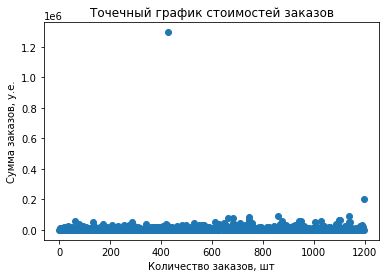

In [52]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество заказов, шт')
plt.ylabel('Сумма заказов, у.е.')
plt.show()

На графике есть выбросы аномально больших, крупных заказов. Сделаем срез графика, чтобы посмотреть без выбросов.

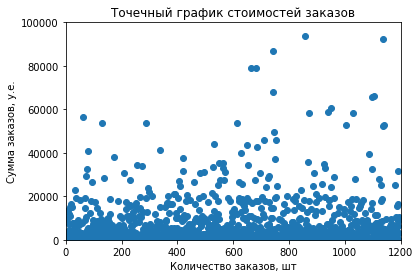

In [53]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.axis([0, 1200, 0, 100000])
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество заказов, шт')
plt.ylabel('Сумма заказов, у.е.')
plt.show()

Большинство пользователей совершают покупки от 15000 до 30000 у.е.


### Посчитайте 95-й и 99-й перцентили стоимости заказов. 

In [54]:
# Выберите границу для определения аномальных заказов.
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более, чем у 5% заказов чек больше 28000 рублей, а у 1% больше 58233 рублей. Пусть 28000 рублей и будут нижней границей.

### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. 

In [55]:
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# Пользователям из разных групп соответствует количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 
sampleA = pd.concat([ordersByUsersA['orders'], 
                     pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - 
                                                  len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - 
                                                  len(ordersByUsersB['orders'])), name='orders')],axis=0)

# Сформулируем гипотезы. Нулевая: различий в конверсии между группами нет. 
# Альтернативная: различия в конверсии между группами есть.
# Применим тест Манна-Уитни
print('\n p-value: {0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительный прирост конверсии по "сырым" данным группы В к конверсии группы А: {0:.3f} \n'.format(sampleB.mean() / sampleA.mean() - 1))


 p-value: 0.017
Относительный прирост конверсии по "сырым" данным группы В к конверсии группы А: 0.138 



p-value < 0.05. Нулевая гипотеза опроверглась, есть различия в конверсии между группами. Относительный прирост конверсии группы В к конверсии группы А равен 14%
    
### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [56]:
# Передадим критерию mannwhitneyu() данные о выручке с заказов.
print('\n p-value: {0:.3f}'.format(
    st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

# Найдём относительные различия в среднем чеке между группами
print('Относительные различия в среднем чеке по "сырым" данным между группами В и А: {0:.3f} \n'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))


 p-value: 0.729
Относительные различия в среднем чеке по "сырым" данным между группами В и А: 0.259 



P-value > 0.05, следовательно между группами нет статистически значимого различия по среднему чеку по "сырым" данным, несмотря на относительную разницу почти в 26%

### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным.   

In [57]:
# Для формирования списка аномальных пользователей примем тех, кто совершил от 2 заказов- это 95 перцентиль в заказах
limit_orders = np.percentile(ordersByUsers['orders'], 95)

# или совершил заказ дороже 28 000 рублей-  это 95 перцентиль в выручке. 
# Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. 
limit_revenue = np.percentile(orders['revenue'], 95)

In [58]:
# Сделаем срезы аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > limit_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > limit_orders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > limit_revenue]['visitorId']

# Объединим срезы в таблице abnormalUsers
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
abnormalUsers.shape[0] # Посчитаем сколько аномальных пользователей повлияли на результат теста

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64


74

In [59]:
# Выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index=np.arange(
                                 visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0
                           )

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index=np.arange(
                                 visitors[visitors['group'] == 'B']['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0
                           )

# Применим статистический критерий Манна-Уитни
print('\n p-value: {0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост конверсии по «очищенным» данным группы В к конверсии группы А: {0:.3f} \n'.format(
    sampleBFiltered.mean()/sampleAFiltered.mean()-1))


 p-value: 0.013
Относительный прирост конверсии по «очищенным» данным группы В к конверсии группы А: 0.173 



Как и в случае с сырыми данными, p-value < 0.05 статистической значимости, различия в конверсии между группами есть. Cегмент группы В на 17% лучше, сегмента группы А. Разница между данными не большая 13.8% и 17.3%.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [60]:
print('\n p-value: {0:.3f}'.format(st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                                       orders[np.logical_and(orders['group'] == 'B',
                                           np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1])
     )

print('Относительные различия в среднем чеке между группами А и В по «очищенным» данным: {0:.3f} \n'.format(orders[
    np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
                       / orders[np.logical_and(
                           orders['group'] == 'A',
                           np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)
     )



 p-value: 0.738
Относительные различия в среднем чеке между группами А и В по «очищенным» данным: -0.020 



Тест показал, что статистически не значимо различие в среднем чеке между группами, а влияние выбросов как раз оказалось очень значимое - по очищенным данным (без выбросов) средний чек в группе В меньше на 2%, а по неочищенным (с выбросами) - больше на 26%. Очень существенное влияние. Но это выборосы, то есть случайности, и по ним нельзя судить о среднем чеке в целом.

## Вывод
- p-value: 0.017. Относительный прирост конверсии по "сырым" данным группы В к конверсии группы А: 0.138. Нулевая гипотеза опроверглась, есть различия в конверсии между группами. 
- p-value: 0.729. Относительные различия в среднем чеке по "сырым" данным между группами В и А: 0.259. Между группами нет статистически значимого различия по среднему чеку по "сырым" данным, несмотря на относительную разницу почти в 26%
- Как и в случае с сырыми данными, p-value < 0.05 статистической значимости, различия в конверсии между группами есть. Cегмент группы В на 17% лучше, сегмента группы А. Разница между данными не большая 13.8% и 17.3%.
- Тест показал, что статистически не значимо различие в среднем чеке между группами, а влияние выбросов как раз оказалось очень значимое - по очищенным данным (без выбросов) средний чек в группе В меньше на 2%, а по неочищенным (с выбросами) - больше на 26%. Очень существенное влияние. 